In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/PLDAC/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PLDAC


In [2]:
!pip install transformers -q
!pip install wandb -q
!pip install sentencepiece -q
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [3]:
# Importing stock libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

from torch import cuda

import psutil
import humanize
import os
import GPUtil as GPU

In [4]:
!nvidia-smi

Sun Feb 27 19:03:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
!wandb login

wandb: Currently logged in as: nam685 (use `wandb login --relogin` to force relogin)


In [9]:
def read_canard(type):
    '''
        type 0: all queries, all answers
        type 1: all queries, last 3 answers
        type 2: all queries, last 1 answers
        type 3: all queries, no answer
    '''
    canard_path = "/content/gdrive/MyDrive/PLDAC/data/canard"
    TYPES = ["_all_all","_all_3","_all_1","_all_0"]
    train = pd.read_csv(f"{canard_path}/train{TYPES[type]}.csv")
    dev = pd.read_csv(f"{canard_path}/dev{TYPES[type]}.csv")
    test = pd.read_csv(f"{canard_path}/test{TYPES[type]}.csv")
    train = pd.concat([train,dev],ignore_index=True)
    return train, test # 35000 train 5000 test

def read_trec(year,version,test_size=0.5):
    assert year==2020 or year==2021
    assert version in range(1,14)
    trec_path = "/content/gdrive/MyDrive/PLDAC/data/treccast/treccastweb-master"
    df = pd.read_csv(f"{trec_path}/{year}/trec{year}_{version}.csv")
    train, test = train_test_split(df, test_size=test_size,random_state=1)
    train = train.reset_index()
    test = test.reset_index()
    return train, test # about 240 train 240 test

def createCQRdata(canard_type,trec_version):
    canard_train, canard_test = read_canard(canard_type)
    trec_train_2020, trec_test_2020 = read_trec(2020,trec_version)
    trec_train_2021, trec_test_2021 = read_trec(2021,trec_version)
    train = pd.concat([canard_train,trec_train_2020,trec_train_2021],ignore_index=True)
    val = pd.concat([canard_test,trec_test_2020,trec_test_2021], ignore_index=True)
    #train = train.sample(frac=1,random_state=1).reset_index(drop=True)
    #val = val.sample(frac=1,random_state=1).reset_index(drop=True)
    return train[["Source","Target"]], val[["Source","Target"]]

(array([1.1767e+04, 1.6196e+04, 5.2070e+03, 1.4790e+03, 3.6500e+02,
        1.2400e+02, 2.9000e+01, 1.1000e+01, 3.0000e+00, 2.0000e+00]),
 array([ 11. ,  43.7,  76.4, 109.1, 141.8, 174.5, 207.2, 239.9, 272.6,
        305.3, 338. ]),
 <a list of 10 Patch objects>)

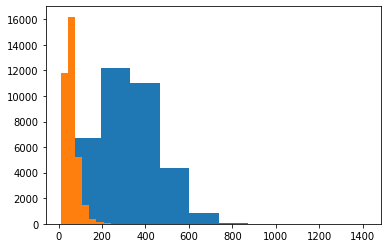

In [12]:
train_tmp, val_tmp = createCQRdata(2,5)
plt.hist(train_tmp.Source.str.len())
plt.hist(train_tmp.Target.str.len())

In [13]:
pd.DataFrame(train_tmp.Source[train_tmp.Source.str.len() > 800]).head()

,Source
2688,Query: Did they eventually bring down the apar...
3448,Query: Did the team celebrate after their winn...
5465,Query: What was Western Reserve? |||| Context:...
8387,Query: Were any family members involved with h...
10633,Query: Did the band tour outside of Australia?...


In [14]:
from torch.utils.data.dataloader import default_collate
from torch.nn.utils.rnn import pad_sequence

def my_collate(batch):
    padded_source_ids = pad_sequence([item['source_ids'] for item in batch], batch_first=True)
    padded_source_mask = pad_sequence([item['source_mask'] for item in batch], batch_first=True)
    padded_target_ids = pad_sequence([item['target_ids'] for item in batch], batch_first=True)
    batch = [{'source_ids':padded_source_ids[i], 'source_mask':padded_source_mask[i],\
              'target_ids':padded_target_ids[i]} for i in range(len(padded_source_ids))]
    return default_collate(batch)

In [15]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, target_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.target_len = target_len
        self.df_target = self.data.Target
        self.df_source = self.data.Source

    def __len__(self):
        return len(self.df_target)

    def __getitem__(self, index):
        df_source = str(self.df_source[index])
        df_source = ' '.join(df_source.split())

        df_target = str(self.df_target[index])
        df_target = ' '.join(df_target.split())

        source = self.tokenizer.batch_encode_plus([df_source], max_length= self.source_len, padding='longest',return_tensors='pt',truncation=True)
        target = self.tokenizer.batch_encode_plus([df_target], max_length= self.target_len, padding='longest',return_tensors='pt',truncation=True)

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            #'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [16]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we enumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        labels = y[:, 1:].clone().detach()
        labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=labels)
        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [17]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=250, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [18]:
def main(canard_type,trec_version):
    # WandB – Initialize a new run
    wandb.init(project="conversational query reformulation")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 8    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 8    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 1        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    config.TARGET_LEN = 256 

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenizer for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    
    # Creation of Dataset and Dataloader
    train_dataset, val_dataset = createCQRdata(canard_type,trec_version)

    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.TARGET_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.TARGET_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0,
        'collate_fn': my_collate
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0,
        'collate_fn': my_collate
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    
    # Defining the model. We are using t5-base model and added a Language model layer on top for generation. 
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    printm()
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)

    # save model
    model.save_pretrained(save_directory=f"./models/CQR/cqr{canard_type}{trec_version}")

    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    printm()
    print('Now generating reformulations on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('./models/predictions.csv')
        print('Output Files generated for review')
    


In [19]:
torch.cuda.empty_cache()

In [20]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.5 GB  |     Proc size: 1.4 GB
GPU RAM Free: 11438MB | Used: 3MB | Util   0% | Total     11441MB


In [ ]:
main(2,5)

wandb: Currently logged in as: nam685 (use `wandb login --relogin` to force relogin)


TRAIN Dataset: (35183, 2)
TEST Dataset: (5799, 2)
Gen RAM Free: 10.4 GB  |     Proc size: 5.0 GB
GPU RAM Free: 11438MB | Used: 3MB | Util   0% | Total     11441MB
Initiating Fine-Tuning for the model on our dataset
Epoch: 0, Loss:  7.292999267578125
Epoch: 0, Loss:  1.1825580596923828
Epoch: 0, Loss:  0.8917543888092041
Epoch: 0, Loss:  0.4397639334201813
